In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

In [21]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/SIG_2021_11_16_no_iso_TEST.arrow')
bg_full = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg_full['is_signal'] = False
# bg_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/FULLBG_2021_11_16_no_iso_TEST.arrow')

In [3]:
bg_ZZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ZZ_RD.arrow')
bg_Zjets_old = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20211129_iso_e4m1_Zjets_RD.arrow')
bg_Zjets = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zjets_RD.arrow')
bg_Zgamma = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zgamma_RD.arrow')
bg_WZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_WZ_RD.arrow')
bg_tZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tZ_RD.arrow')
bg_tWZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tWZ_RD.arrow')
bg_ttZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ttZ_RD.arrow')
bg_other = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_others_RD.arrow')

bg_sources = [bg_ZZ, bg_Zjets, bg_Zgamma, bg_WZ, bg_tZ, bg_tWZ, bg_ttZ, bg_other]

In [4]:
for df in bg_sources:
    print(sum(df.wgt) / sum(bg_full.wgt))

0.9717740665613699
0.008909331116206785
0.0010556883632736617
0.004347097929154949
0.00016711686720929022
0.0025379501654372405
0.005859107932870372
0.006691005792313908


In [5]:
# train_feats = ['Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 'pt_1', 'pt_2', 'Wlep2_pt_sqrt']
# train_feats = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
#                'Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 
#                'Zlep1_phi', 'Zlep2_phi', 'Wlep1_phi', 'Wlep2_phi', 
#                'Zlep1_eta', 'Zlep2_eta', 'Wlep1_eta', 'Wlep2_eta',
#                'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid', 'Wlep2_pid',
#                'Zlep1_pt', 'Zlep2_pt', 'Wlep1_pt', 'Wlep2_pt',
#                'METSig', 'MET', 'Nlep', 'Njet',
#                'other_mass', 'leptonic_HT', 'total_HT', 'HT', 
#                'SR']

train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 'Zcand_mass', 'chisq']])

X = pd.concat([sig[train_feats_raw], bg_full[train_feats_raw]], ignore_index=True)

In [6]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg_full] + bg_sources:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

# Signal vs ZZ

ZZ events account for

In [7]:
current_bg = bg_ZZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

97.177406656137

percent of the total background. The amount relative to signal is

In [8]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 1626.9569530451513 %
Weight: 8163.991874259401 %


In [9]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [12]:
# Regenerate test samples
_, sig_test = train_test_split(sig[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)
_, bg_test = train_test_split(current_bg[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[train_feats_raw], bg_test[train_feats_raw]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

Now we scan over tests

In [13]:
completed_tests = ['models/background_id_models/' + t for t in os.listdir('models/background_id_models/') 
                   if t.startswith('classifier_ZZ') and t.endswith('_history.pkl')]
completed_tests = [t.replace('_history.pkl', '') for t in completed_tests]
completed_tests

['models/background_id_models/classifier_ZZ_train_feat_test_0',
 'models/background_id_models/classifier_ZZ_train_feat_test_1',
 'models/background_id_models/classifier_ZZ_train_feat_test_2',
 'models/background_id_models/classifier_ZZ_train_feat_test_3',
 'models/background_id_models/classifier_ZZ_train_feat_test_4']

In [14]:
models = [None] * len(completed_tests)

for i, test in enumerate(completed_tests):
    models[i] = keras.models.load_model(test)
    
    x_test['output_test_' + str(i)] = models[i].predict(x_test[train_feat_sets[i]], batch_size=10000)
    sig_test['output_test_' + str(i)] = models[i].predict(sig_test[train_feat_sets[i]], batch_size=10000)
    bg_test['output_test_' + str(i)] = models[i].predict(bg_test[train_feat_sets[i]], batch_size=10000)

2022-01-31 04:10:34.468493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 04:10:34.472750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-31 04:10:34.472833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-31 04:10:34.472865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-31 04:10:34.472878: I tensorflow/stream_executor/plat

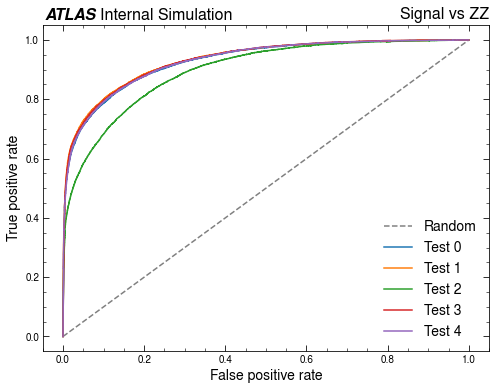

In [155]:
# Generate ROC curves
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], ls='--', color='grey', label='Random')

for i, test in enumerate(completed_tests):
    fpr, tpr, _ = roc_curve(y_test, x_test['output_test_' + str(i)], sample_weight=w_test)
    
    plt.plot(fpr, tpr, label='Test ' + str(i))
    
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Signal vs ZZ', fontsize=16, loc='right')

atlasify('Internal Simulation', outside=True)

plt.savefig('plots/background_id_models/sig_vs_zz_train_feat_test_roc.png', 
            pad_inches=0.05, bbox_inches='tight')
plt.savefig('plots/background_id_models/sig_vs_zz_train_feat_test_roc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

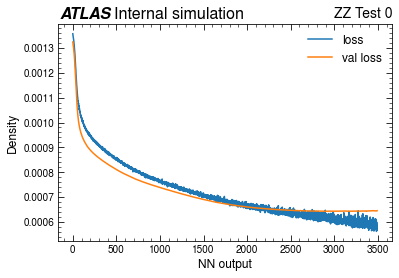

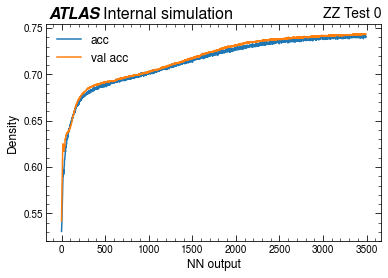

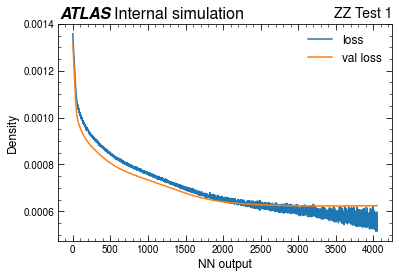

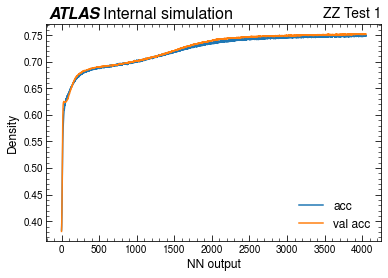

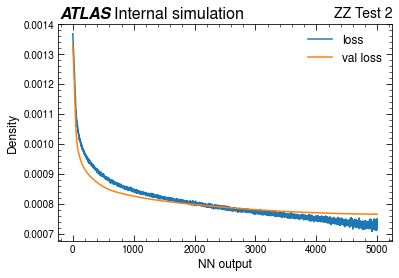

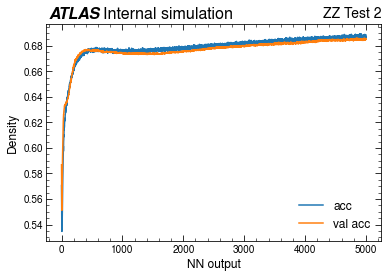

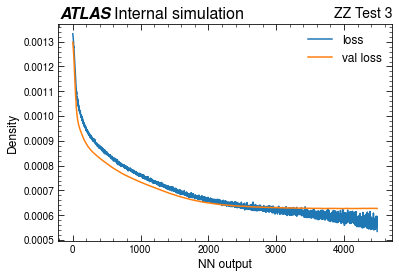

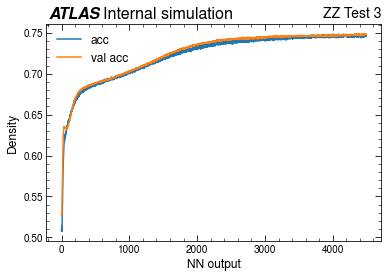

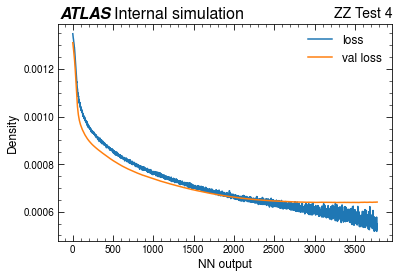

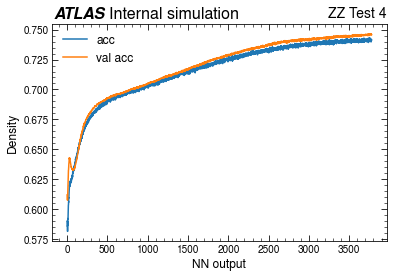

In [156]:
# Generate training history plots

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    with open(test + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('ZZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_zz/train_feat_test/test_' + str(i) + '_loss.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_zz/train_feat_test/test_' + str(i) + '_loss.pdf', 
            pad_inches=0.05, bbox_inches='tight')
    
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('ZZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_zz/train_feat_test/test_' + str(i) + '_acc.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_zz/train_feat_test/test_' + str(i) + '_acc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

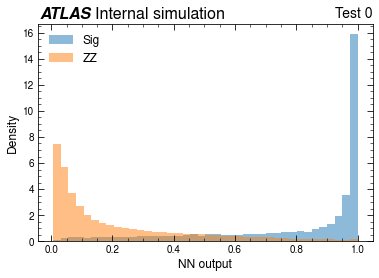

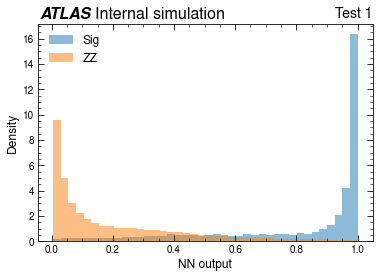

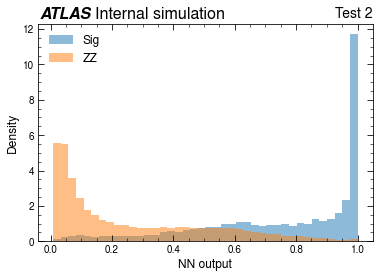

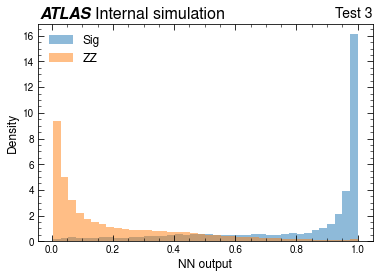

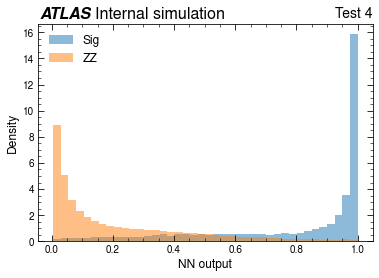

In [158]:
# Generate signal vs background histograms

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    _, b, _ = plt.hist(sig_test['output_test_' + str(i)], bins=40, weights=sig_test.wgt, label='Sig', 
                       density=True, alpha=0.5)
    plt.hist(bg_test['output_test_' + str(i)], bins=b, weights=bg_test.wgt, label='ZZ', 
             density=True, alpha=0.5)
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_zz/train_feat_test/test_' + str(i) + '_output.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_zz/train_feat_test/test_' + str(i) + '_output.pdf', 
            pad_inches=0.05, bbox_inches='tight')

# Signal vs Z + jets

Z + jets events account for

In [140]:
current_bg = bg_Zjets
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.8909331116206785

percent of the total background. The amount relative to signal is

In [141]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 0.1984007695545001 %
Weight: 74.84837200397259 %


In [142]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [143]:
# Regenerate test samples
_, sig_test = train_test_split(sig[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)
_, bg_test = train_test_split(current_bg[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)

n_sig = sum(sig_train.wgt)
n_bg = sum(bg_train.wgt)

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[train_feats_raw], bg_test[train_feats_raw]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

Now we scan over tests

In [144]:
completed_tests = ['models/background_id_models/' + t for t in os.listdir('models/background_id_models/') 
                   if t.startswith('classifier_Zjets') and t.endswith('_history.pkl')]
completed_tests = [t.replace('_history.pkl', '') for t in completed_tests]
completed_tests

['models/background_id_models/classifier_Zjets_train_feat_test_0',
 'models/background_id_models/classifier_Zjets_train_feat_test_1',
 'models/background_id_models/classifier_Zjets_train_feat_test_2',
 'models/background_id_models/classifier_Zjets_train_feat_test_3',
 'models/background_id_models/classifier_Zjets_train_feat_test_4']

In [145]:
models = [None] * len(completed_tests)

for i, test in enumerate(completed_tests):
    models[i] = keras.models.load_model(test)
    
    x_test['output_test_' + str(i)] = models[i].predict(x_test[train_feat_sets[i]], batch_size=10000)
    sig_test['output_test_' + str(i)] = models[i].predict(sig_test[train_feat_sets[i]], batch_size=10000)
    bg_test['output_test_' + str(i)] = models[i].predict(bg_test[train_feat_sets[i]], batch_size=10000)

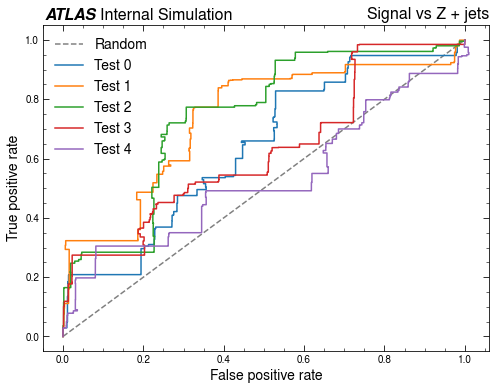

In [146]:
# Generate ROC curves
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], ls='--', color='grey', label='Random')

for i, test in enumerate(completed_tests):
    fpr, tpr, _ = roc_curve(y_test, x_test['output_test_' + str(i)], sample_weight=w_test)
    
    plt.plot(fpr, tpr, label='Test ' + str(i))
    
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Signal vs Z + jets', fontsize=16, loc='right')

atlasify('Internal Simulation', outside=True)

plt.savefig('plots/background_id_models/sig_vs_zjets_train_feat_test_roc.png', 
            pad_inches=0.05, bbox_inches='tight')
plt.savefig('plots/background_id_models/sig_vs_zjets_train_feat_test_roc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

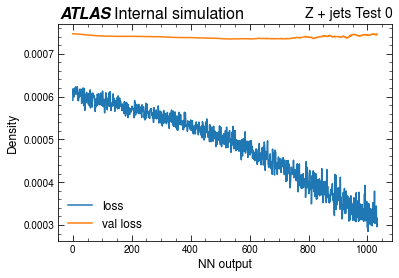

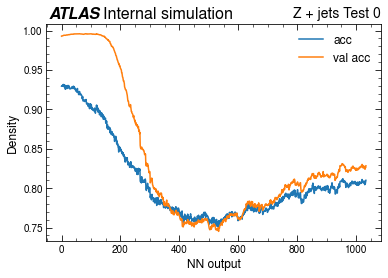

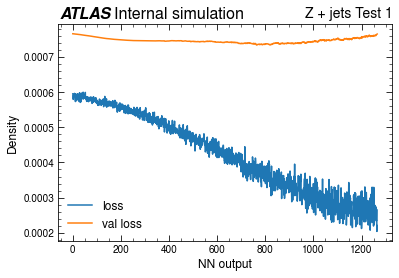

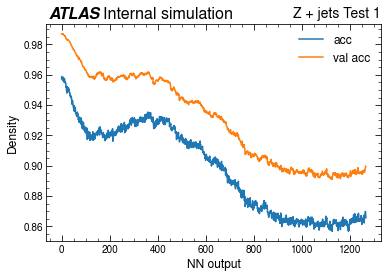

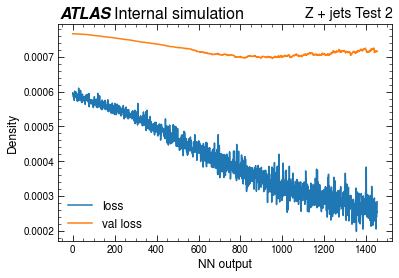

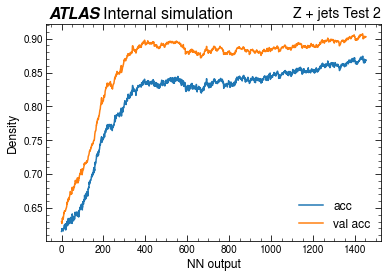

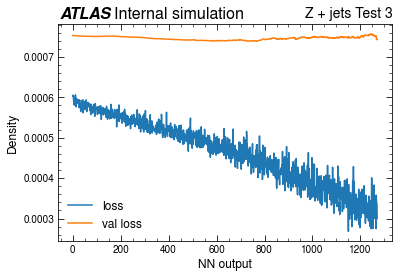

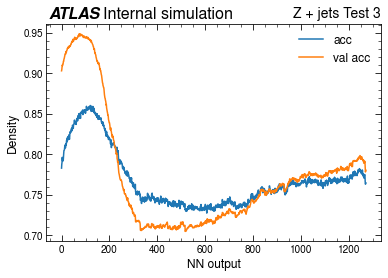

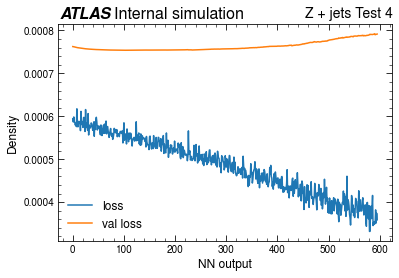

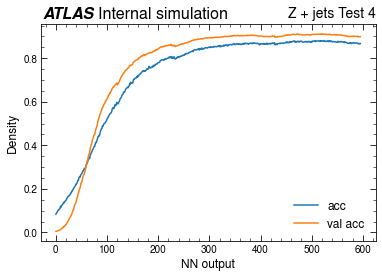

In [147]:
# Generate training history plots

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    with open(test + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Z + jets Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_zjets/train_feat_test/test_' + str(i) + '_loss.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_zjets/train_feat_test/test_' + str(i) + '_loss.pdf', 
            pad_inches=0.05, bbox_inches='tight')
    
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Z + jets Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_zjets/train_feat_test/test_' + str(i) + '_acc.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_zjets/train_feat_test/test_' + str(i) + '_acc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

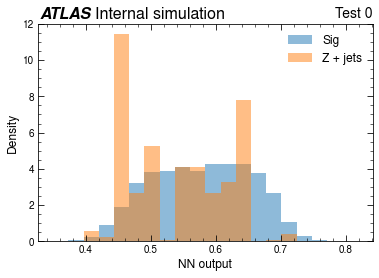

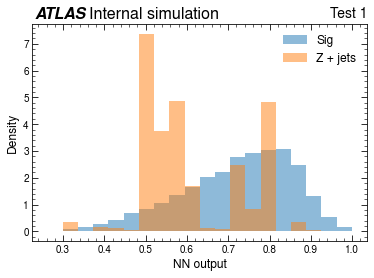

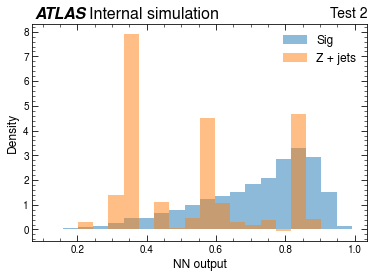

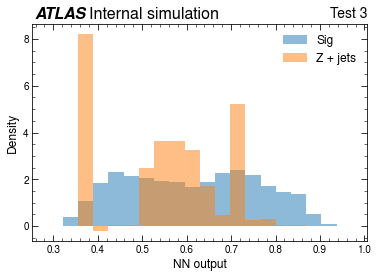

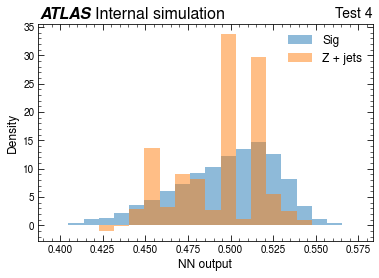

In [148]:
# Generate signal vs background histograms

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    _, b, _ = plt.hist(sig_test['output_test_' + str(i)], bins=20, weights=sig_test.wgt, label='Sig', 
                       density=True, alpha=0.5)
    plt.hist(bg_test['output_test_' + str(i)], bins=b, weights=bg_test.wgt, label='Z + jets', 
             density=True, alpha=0.5)
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_zjets/train_feat_test/test_' + str(i) + '_output.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_zjets/train_feat_test/test_' + str(i) + '_output.pdf', 
            pad_inches=0.05, bbox_inches='tight')

# Signal vs ttZ

ttZ events account for

In [110]:
current_bg = bg_ttZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.5859107932870372

percent of the total background. The amount relative to signal is

In [111]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 12.496242409667529 %
Weight: 49.22307684503504 %


In [112]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [113]:
# Regenerate test samples
_, sig_test = train_test_split(sig[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)
_, bg_test = train_test_split(current_bg[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)

n_sig = sum(sig_train.wgt)
n_bg = sum(bg_train.wgt)

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[train_feats_raw], bg_test[train_feats_raw]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

Now we scan over tests

In [114]:
completed_tests = ['models/background_id_models/' + t for t in os.listdir('models/background_id_models/') 
                   if t.startswith('classifier_ttZ') and t.endswith('_history.pkl')]
completed_tests = [t.replace('_history.pkl', '') for t in completed_tests]
completed_tests

['models/background_id_models/classifier_ttZ_train_feat_test_0',
 'models/background_id_models/classifier_ttZ_train_feat_test_1',
 'models/background_id_models/classifier_ttZ_train_feat_test_2',
 'models/background_id_models/classifier_ttZ_train_feat_test_3',
 'models/background_id_models/classifier_ttZ_train_feat_test_4']

In [115]:
models = [None] * len(completed_tests)

for i, test in enumerate(completed_tests):
    models[i] = keras.models.load_model(test)
    
    x_test['output_test_' + str(i)] = models[i].predict(x_test[train_feat_sets[i]], batch_size=10000)
    sig_test['output_test_' + str(i)] = models[i].predict(sig_test[train_feat_sets[i]], batch_size=10000)
    bg_test['output_test_' + str(i)] = models[i].predict(bg_test[train_feat_sets[i]], batch_size=10000)

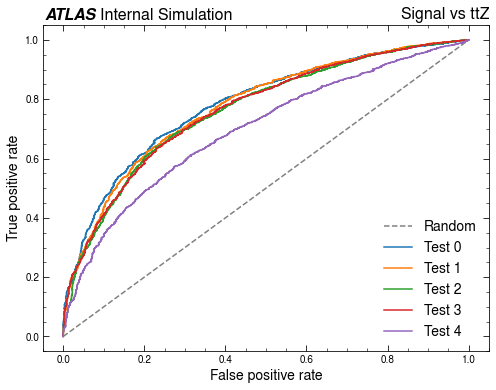

In [125]:
# Generate ROC curves
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], ls='--', color='grey', label='Random')

for i, test in enumerate(completed_tests):
    fpr, tpr, _ = roc_curve(y_test, x_test['output_test_' + str(i)], sample_weight=w_test)
    
    plt.plot(fpr, tpr, label='Test ' + str(i))
    
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Signal vs ttZ', fontsize=16, loc='right')

atlasify('Internal Simulation', outside=True)

plt.savefig('plots/background_id_models/sig_vs_ttz_train_feat_test_roc.png', 
            pad_inches=0.05, bbox_inches='tight')
plt.savefig('plots/background_id_models/sig_vs_ttz_train_feat_test_roc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

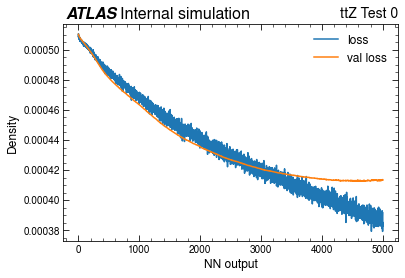

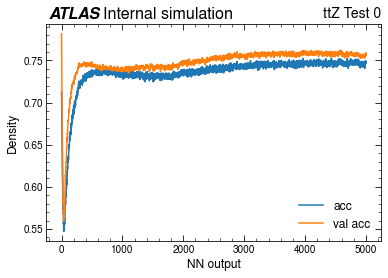

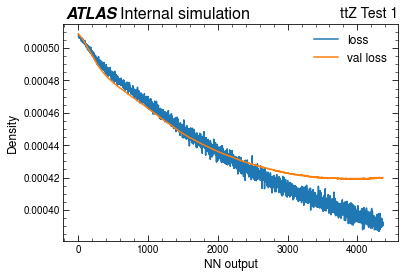

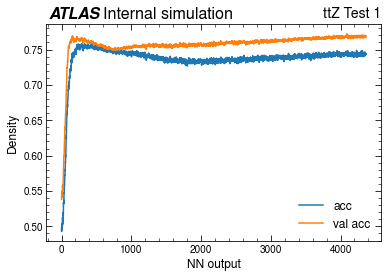

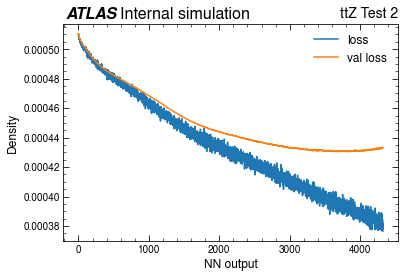

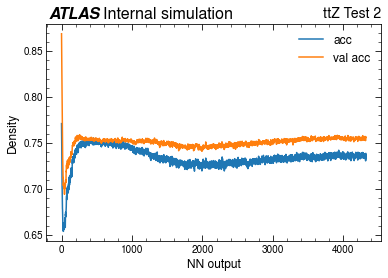

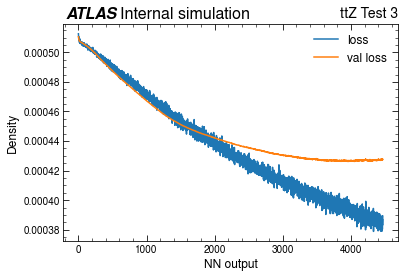

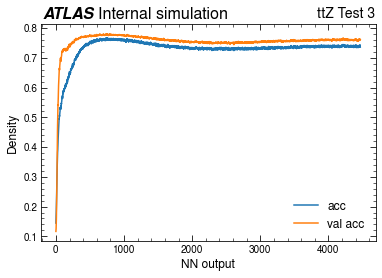

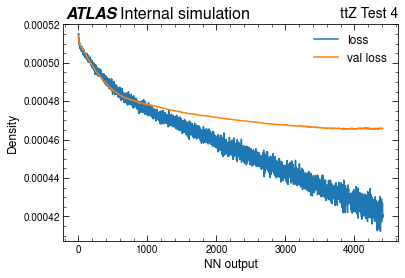

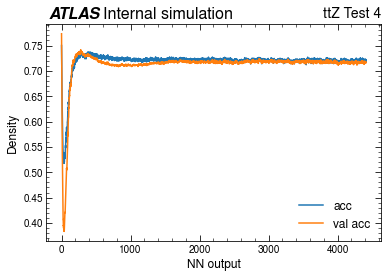

In [118]:
# Generate training history plots

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    with open(test + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('ttZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_ttz/train_feat_test/test_' + str(i) + '_loss.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_ttz/train_feat_test/test_' + str(i) + '_loss.pdf', 
            pad_inches=0.05, bbox_inches='tight')
    
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('ttZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_ttz/train_feat_test/test_' + str(i) + '_acc.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_ttz/train_feat_test/test_' + str(i) + '_acc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

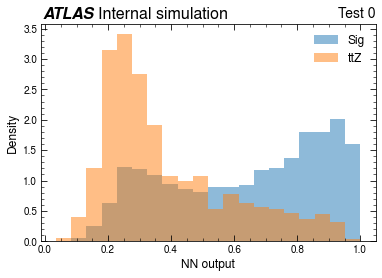

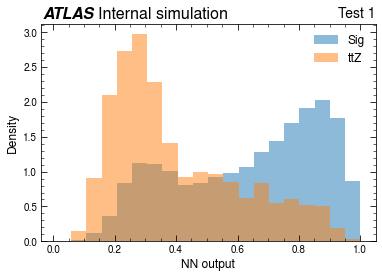

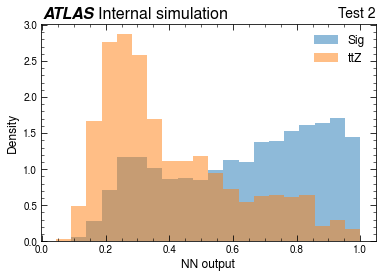

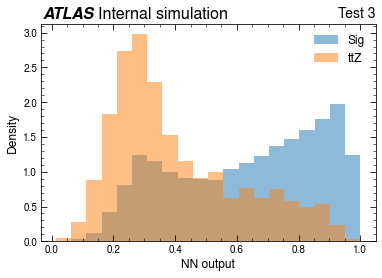

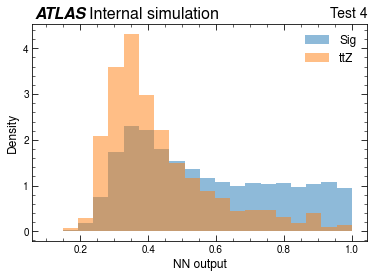

In [119]:
# Generate signal vs background histograms

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    _, b, _ = plt.hist(sig_test['output_test_' + str(i)], bins=20, weights=sig_test.wgt, label='Sig', 
                       density=True, alpha=0.5)
    plt.hist(bg_test['output_test_' + str(i)], bins=b, weights=bg_test.wgt, label='ttZ', 
             density=True, alpha=0.5)
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_ttz/train_feat_test/test_' + str(i) + '_output.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_ttz/train_feat_test/test_' + str(i) + '_output.pdf', 
            pad_inches=0.05, bbox_inches='tight')

# Signal vs WZ

WZ events account for

In [126]:
current_bg = bg_WZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.43470979291549483

percent of the total background. The amount relative to signal is

In [127]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 2.1478386340407623 %
Weight: 36.52049729605499 %


In [128]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [129]:
# Regenerate test samples
_, sig_test = train_test_split(sig[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)
_, bg_test = train_test_split(current_bg[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)

n_sig = sum(sig_train.wgt)
n_bg = sum(bg_train.wgt)

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[train_feats_raw], bg_test[train_feats_raw]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

Now we scan over tests

In [130]:
completed_tests = ['models/background_id_models/' + t for t in os.listdir('models/background_id_models/') 
                   if t.startswith('classifier_WZ') and t.endswith('_history.pkl')]
completed_tests = [t.replace('_history.pkl', '') for t in completed_tests]
completed_tests

['models/background_id_models/classifier_WZ_train_feat_test_0',
 'models/background_id_models/classifier_WZ_train_feat_test_1',
 'models/background_id_models/classifier_WZ_train_feat_test_2',
 'models/background_id_models/classifier_WZ_train_feat_test_3',
 'models/background_id_models/classifier_WZ_train_feat_test_4']

In [131]:
models = [None] * len(completed_tests)

for i, test in enumerate(completed_tests):
    models[i] = keras.models.load_model(test)
    
    x_test['output_test_' + str(i)] = models[i].predict(x_test[train_feat_sets[i]], batch_size=10000)
    sig_test['output_test_' + str(i)] = models[i].predict(sig_test[train_feat_sets[i]], batch_size=10000)
    bg_test['output_test_' + str(i)] = models[i].predict(bg_test[train_feat_sets[i]], batch_size=10000)

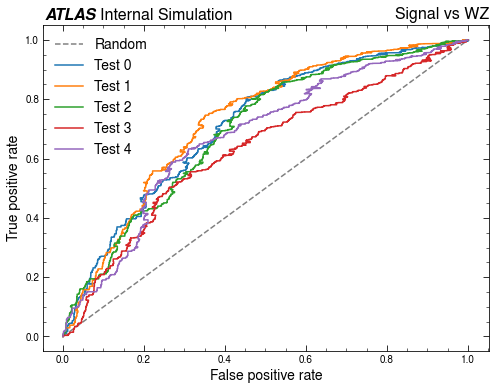

In [132]:
# Generate ROC curves
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], ls='--', color='grey', label='Random')

for i, test in enumerate(completed_tests):
    fpr, tpr, _ = roc_curve(y_test, x_test['output_test_' + str(i)], sample_weight=w_test)
    
    plt.plot(fpr, tpr, label='Test ' + str(i))
    
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Signal vs WZ', fontsize=16, loc='right')

atlasify('Internal Simulation', outside=True)

plt.savefig('plots/background_id_models/sig_vs_wz_train_feat_test_roc.png', 
            pad_inches=0.05, bbox_inches='tight')
plt.savefig('plots/background_id_models/sig_vs_wz_train_feat_test_roc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

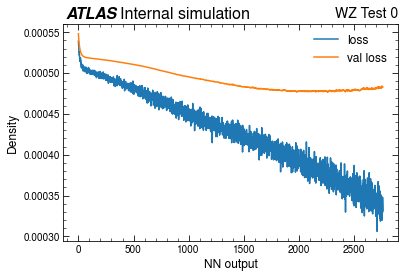

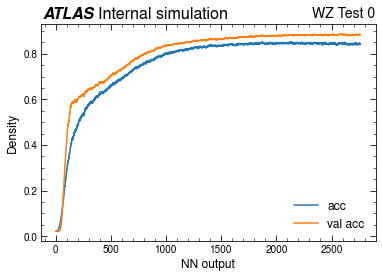

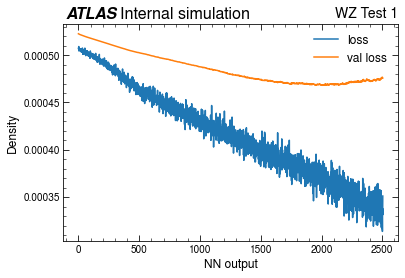

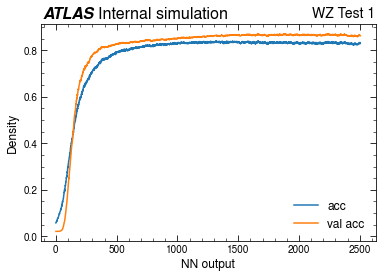

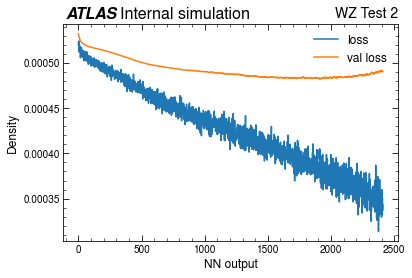

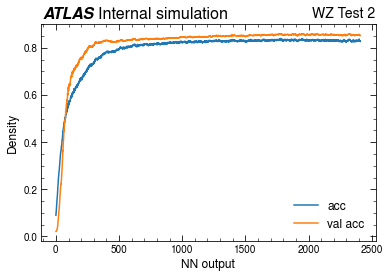

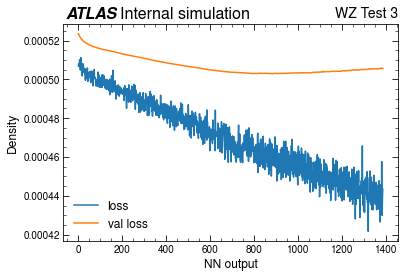

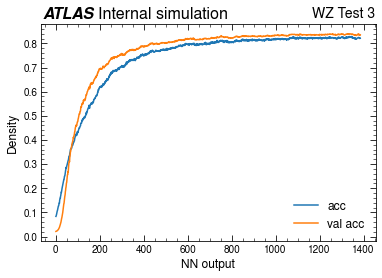

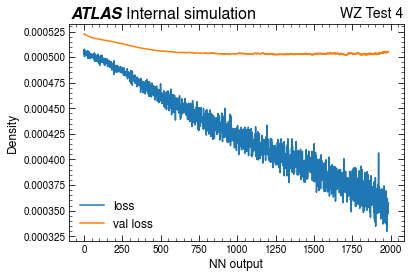

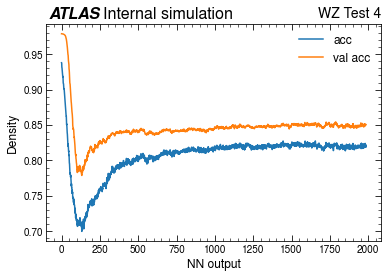

In [100]:
# Generate training history plots

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    with open(test + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('WZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_wz/train_feat_test/test_' + str(i) + '_loss.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_wz/train_feat_test/test_' + str(i) + '_loss.pdf', 
            pad_inches=0.05, bbox_inches='tight')
    
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('WZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_wz/train_feat_test/test_' + str(i) + '_acc.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_wz/train_feat_test/test_' + str(i) + '_acc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

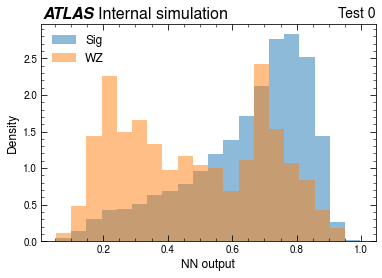

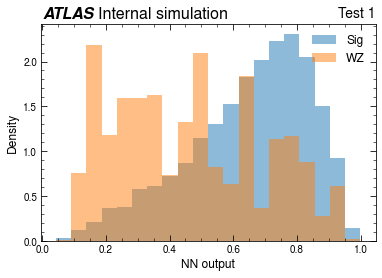

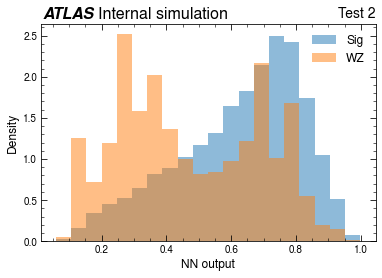

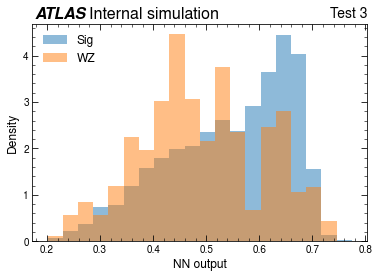

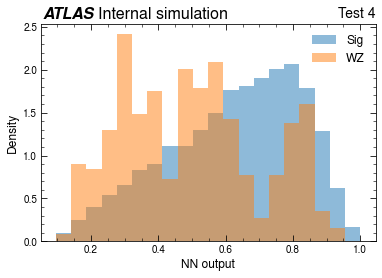

In [97]:
# Generate signal vs background histograms

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    _, b, _ = plt.hist(sig_test['output_test_' + str(i)], bins=20, weights=sig_test.wgt, label='Sig', 
                       density=True, alpha=0.5)
    plt.hist(bg_test['output_test_' + str(i)], bins=b, weights=bg_test.wgt, label='WZ', 
             density=True, alpha=0.5)
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_wz/train_feat_test/test_' + str(i) + '_output.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_wz/train_feat_test/test_' + str(i) + '_output.pdf', 
            pad_inches=0.05, bbox_inches='tight')

# Signal vs other

other events account for

In [133]:
current_bg = bg_other
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.6691005792313908

percent of the total background. The amount relative to signal is

In [134]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 0.5516142608068297 %
Weight: 56.2119517269744 %


In [135]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [136]:
# Regenerate test samples
_, sig_test = train_test_split(sig[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)
_, bg_test = train_test_split(current_bg[train_feats_raw + ['wgt']], train_size=0.5, random_state=314)

n_sig = sum(sig_train.wgt)
n_bg = sum(bg_train.wgt)

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[train_feats_raw], bg_test[train_feats_raw]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

Now we scan over tests

In [137]:
completed_tests = ['models/background_id_models/' + t for t in os.listdir('models/background_id_models/') 
                   if t.startswith('classifier_other') and t.endswith('_history.pkl')]
completed_tests = [t.replace('_history.pkl', '') for t in completed_tests]

In [138]:
models = [None] * len(completed_tests)

for i, test in enumerate(completed_tests):
    models[i] = keras.models.load_model(test)
    
    x_test['output_test_' + str(i)] = models[i].predict(x_test[train_feat_sets[i]], batch_size=10000)
    sig_test['output_test_' + str(i)] = models[i].predict(sig_test[train_feat_sets[i]], batch_size=10000)
    bg_test['output_test_' + str(i)] = models[i].predict(bg_test[train_feat_sets[i]], batch_size=10000)

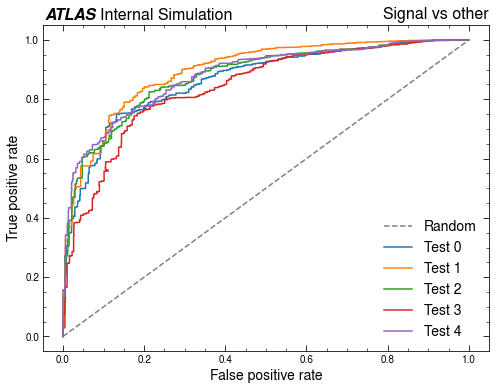

In [139]:
# Generate ROC curves
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], ls='--', color='grey', label='Random')

for i, test in enumerate(completed_tests):
    fpr, tpr, _ = roc_curve(y_test, x_test['output_test_' + str(i)], sample_weight=w_test)
    
    plt.plot(fpr, tpr, label='Test ' + str(i))
    
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Signal vs other', fontsize=16, loc='right')

atlasify('Internal Simulation', outside=True)

plt.savefig('plots/background_id_models/sig_vs_other_train_feat_test_roc.png', 
            pad_inches=0.05, bbox_inches='tight')
plt.savefig('plots/background_id_models/sig_vs_other_train_feat_test_roc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

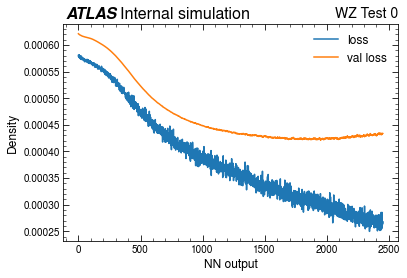

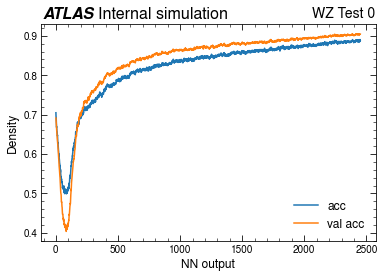

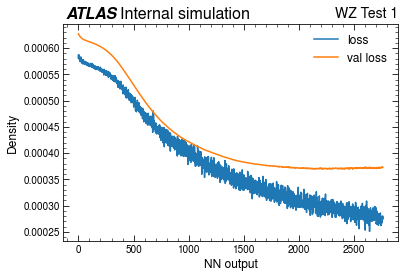

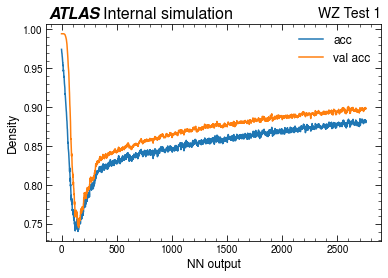

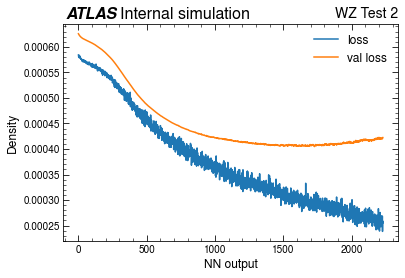

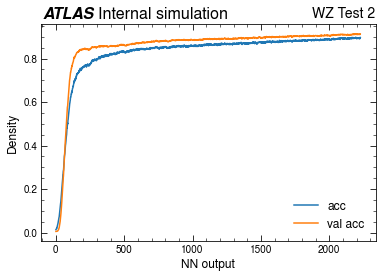

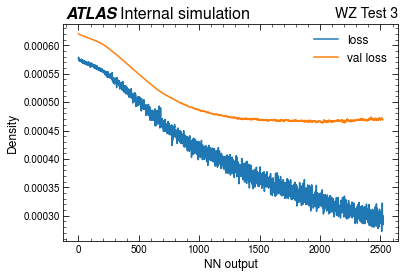

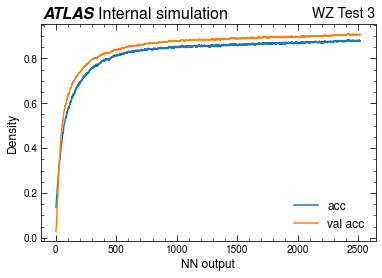

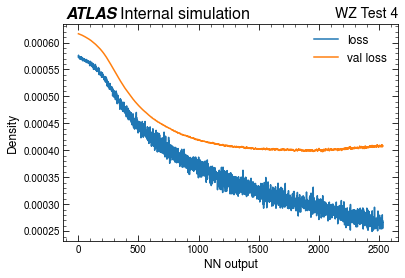

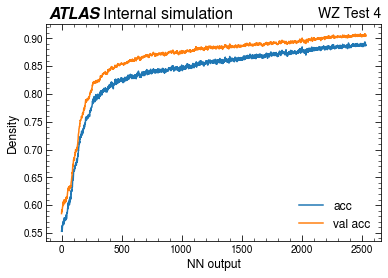

In [108]:
# Generate training history plots

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    with open(test + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('WZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_other/train_feat_test/test_' + str(i) + '_loss.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_other/train_feat_test/test_' + str(i) + '_loss.pdf', 
            pad_inches=0.05, bbox_inches='tight')
    
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('WZ Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_other/train_feat_test/test_' + str(i) + '_acc.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_other/train_feat_test/test_' + str(i) + '_acc.pdf', 
            pad_inches=0.05, bbox_inches='tight')

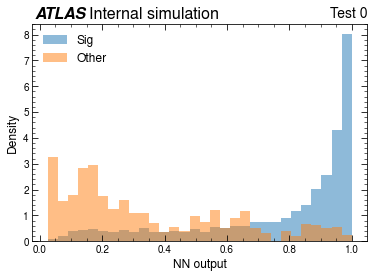

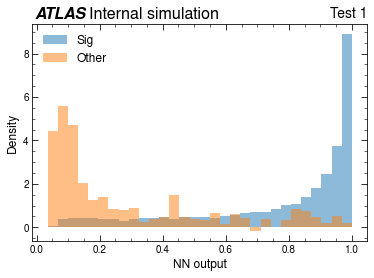

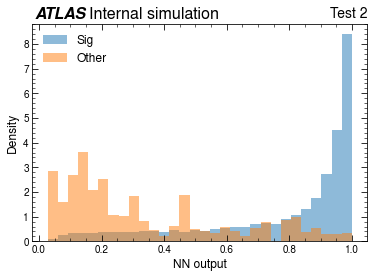

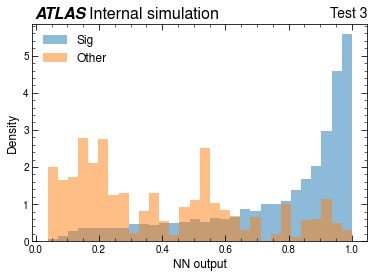

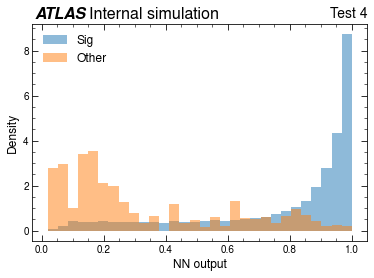

In [109]:
# Generate signal vs background histograms

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    _, b, _ = plt.hist(sig_test['output_test_' + str(i)], bins=30, weights=sig_test.wgt, label='Sig', 
                       density=True, alpha=0.5)
    plt.hist(bg_test['output_test_' + str(i)], bins=b, weights=bg_test.wgt, label='Other', 
             density=True, alpha=0.5)
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig('plots/background_id_models/sig_vs_other/train_feat_test/test_' + str(i) + '_output.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig('plots/background_id_models/sig_vs_other/train_feat_test/test_' + str(i) + '_output.pdf', 
            pad_inches=0.05, bbox_inches='tight')